In [1]:
import asreview as asr
from asreview.models.balancers import Balanced
from asreview.models.queriers import Max
from asreview.models.classifiers import SVM
from asreviewcontrib.dory.classifiers.neural_networks import DynamicNNClassifier  # noqa:F401
from asreviewcontrib.dory.feature_extractors.transformer_embeddings import MXBAI
from sklearn.decomposition import NMF
from cockatiel.cockatiel.sampling import ScipySobolSequence
from cockatiel.cockatiel.sobol import SobolEstimator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dataclasses import dataclass, field
import os
import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktLanguageVars
from collections import Counter
import re
import imgkit
from imgkit.config import Config
from IPython.core.display import HTML
import spacy
from tqdm import tqdm

# nlp = spacy.load("en_core_web_sm")
# # python -m spacy download en_core_web_sm
# nltk.download(info_or_id="punkt_tab")
# nltk.download("stopwords")
# stop_words = set(stopwords.words("english"))

2025-08-07 17:10:54,742 SequenceTagger predicts: Dictionary with 47 tags: O, S-NP, B-NP, E-NP, I-NP, S-VP, B-VP, E-VP, I-VP, S-PP, B-PP, E-PP, I-PP, S-ADVP, B-ADVP, E-ADVP, I-ADVP, S-SBAR, B-SBAR, E-SBAR, I-SBAR, S-ADJP, B-ADJP, E-ADJP, I-ADJP, S-PRT, B-PRT, E-PRT, I-PRT, S-CONJP, B-CONJP, E-CONJP, I-CONJP, S-INTJ, B-INTJ, E-INTJ, I-INTJ, S-LST, B-LST, E-LST, I-LST, S-UCP, B-UCP, E-UCP, I-UCP, <START>, <STOP>


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\5927226\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\5927226\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Load Data and Initialize Active Learning Cycle

dataset = "Hall_2012"

data = asr.load_dataset(f"data/{dataset}.csv")

alc = asr.ActiveLearningCycle(
    # classifier=DynamicNNClassifier(),
    classifier=SVM(max_iter=5000, loss="squared_hinge", C=0.067),  # classifier c(x)
    feature_extractor=MXBAI(normalize=False),
    balancer=Balanced(ratio=9.724),
    querier=Max(),
)

In [3]:
# Load or create the embedding matrix

embedding_path = f"data/{dataset}_embedding_matrix.pkl"

if not os.path.exists(embedding_path):
    embedding_matrix = alc.transform(data)
    pd.DataFrame(embedding_matrix).to_pickle(embedding_path)
    embedding_matrix = np.array(embedding_matrix)
else:
    embedding_matrix = pd.read_pickle(embedding_path)
    embedding_matrix = np.array(embedding_matrix)


In [4]:
# Normalize the embedding matrix

def normalize_embedding(fm) -> np.ndarray:
    return (fm - fm.min()) / (fm.max() - fm.min())


@dataclass
class EmbeddingNormalizer:
    base_embedding: np.ndarray
    embedding_min: float = field(init=False)
    embedding_max: float = field(init=False)

    def __post_init__(self):
        self.embedding_min = float(self.base_embedding.min())
        self.embedding_max = float(self.base_embedding.max())

    def normalize(self, embedding=None) -> np.ndarray:
        if embedding is None:
            embedding = self.base_embedding
        if self.embedding_max - self.embedding_min == 0:
            return np.zeros_like(embedding)
        return (embedding - self.embedding_min) / (
            self.embedding_max - self.embedding_min
        )


embedding_normalizer = EmbeddingNormalizer(embedding_matrix)

normalized_embedding_matrix: np.ndarray = embedding_normalizer.normalize(
    embedding_matrix
)

In [5]:
# Run ASReview simulation
simulate = asr.Simulate(  # c(A) in the cycler
    X=normalized_embedding_matrix,
    labels=list(data["included"]),
    cycles=[alc],
    skip_transform=True,
)

simulate.label(list(range(100)))
simulate.review()

Records labeled       :  13%|█▎        | 1124/8793 [15:39<1:57:17,  1.09it/s]


Loss: 0.005
NDCG: 0.871


In [6]:
# Create helper functions and classes for Sobol sensitivity analysis

class JansenEstimator(SobolEstimator):
    def __call__(self, masks, outputs, nb_design):
        nb_dim = self.masks_dim(masks)
        sampling_a, _, replication_c = self.split_abc(outputs, nb_design, nb_dim)
        mu_a = np.mean(sampling_a)
        var = np.sum([(v - mu_a) ** 2 for v in sampling_a]) / (len(sampling_a) - 1)
        eps = 1e-12
        if var < eps:
            return np.zeros(nb_dim)
        stis = [
            np.sum((sampling_a - replication_c[i]) ** 2.0) / (2 * nb_design * var)
            for i in range(nb_dim)
        ]
        return self.post_process(stis, masks)

def get_proba_from_cycle(X: np.ndarray, simulate: asr.Simulate = simulate):
    try:
        proba = simulate.cycles[0].classifier.predict_proba(X)
        return proba

    except AttributeError:
        try:
            scores = simulate.cycles[0].classifier.decision_function(X).reshape(-1, 1)
            pos = np.maximum(scores, 0.0).reshape(-1, 1)
            neg = np.maximum(-scores, 0.0).reshape(-1, 1)
            return np.hstack([neg, pos])

        except AttributeError:
            raise AttributeError(
                "Not possible to compute probabilities or "
                "decision function for this classifier."
            )

def sobol_importance(
    activations: np.ndarray,
    class_id: int,
    W: np.ndarray,
    components: int,
):
    sobol_nb_design: int = 64
    n_samples = activations.shape[0]
    masks = ScipySobolSequence()(components, nb_design=sobol_nb_design)
    estimator = JansenEstimator()

    importances = []

    for i in range(n_samples):
        act = activations[i]

        perturbation = masks @ W
        perturbated_activations = act[None, :] + perturbation * act[None, :]
        y_pred = get_proba_from_cycle(perturbated_activations)[:, class_id]

        stis = estimator(masks, y_pred, sobol_nb_design)
        importances.append(stis)

    global_importance = np.mean(importances, axis=0)

    return global_importance

In [7]:
# Get the positive class embedding matrix
labels = np.array(simulate.labels)
pos_normalized_embedding_matrix = normalized_embedding_matrix[np.array(simulate.labels) == 1]

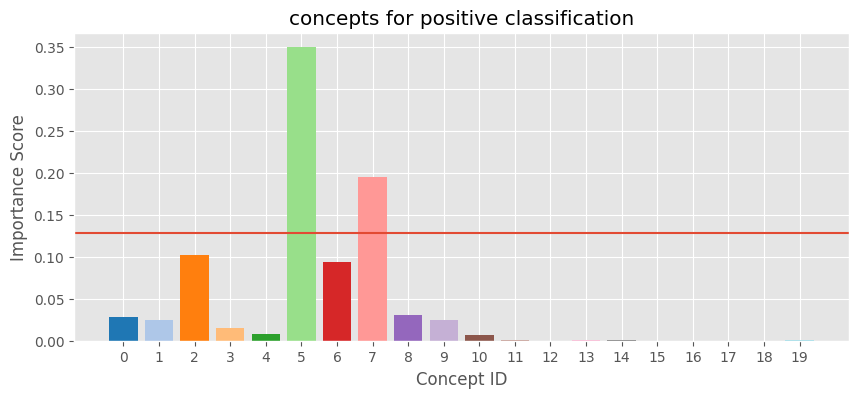

Number of concepts over mean + std: 2


In [8]:
# Init the NMF
factorization = NMF(n_components=20, max_iter=10000)

# Fit the NMF model to the positive normalized embedding matrix
u_matrix: np.ndarray = factorization.fit_transform(
    pos_normalized_embedding_matrix
)  # concept coefficient matrix
w_matrix: np.ndarray = factorization.components_  # concept base matrix

# Compute the concept importance using Sobol's method
pos_concept_importance = sobol_importance(
    activations=pos_normalized_embedding_matrix,
    class_id=1,
    W=w_matrix,
    components=factorization.n_components,
)

threshold = pos_concept_importance.mean() + pos_concept_importance.std()

# Plot the results
plt.figure(figsize=(22, 4))

plt.subplot(122)
plt.bar(
    range(len(pos_concept_importance)),
    pos_concept_importance,
    color=plt.get_cmap("tab20").colors,
    tick_label=range(len(pos_concept_importance)),
)
plt.axhline(threshold)
plt.title("concepts for positive classification")

# label axes
plt.xlabel("Concept ID")
plt.ylabel("Importance Score")

plt.show()

# calculate number of concepts over pos_concept_importance.std()
num_concepts = np.sum(pos_concept_importance > (pos_concept_importance.std() + pos_concept_importance.mean()))
print(f"Number of concepts over mean + std: {num_concepts}")

In [9]:
df_concept_aligned = data.get_df()[["title", "abstract"]]
df_concept_aligned = df_concept_aligned[labels == 1]
df_concept_aligned["text"] = (
    simulate.cycles[0]
    .feature_extractor.steps[0][1]
    .transform(df_concept_aligned[["title", "abstract"]])
)
df_concept_aligned["u"] = list(u_matrix)
df_concept_aligned["a"] = list(pos_normalized_embedding_matrix)

In [10]:
# Get the top concepts based on the threshold
top_cids = np.where(pos_concept_importance > threshold)[0]


In [11]:
# rows = []
# for cid in top_cids:
#     best_ids = np.argsort(u_matrix[:, cid])[::-1][:10]
#     for i in best_ids:
#         rows.append({"text": df_concept_aligned.iloc[i]["text"], "concept_id": cid})

# df_top_abs = pd.DataFrame(data=rows)

# ps = PorterStemmer()
# top_words_per_concept = {}

# for concept in top_cids:
#     texts = df_top_abs[df_top_abs["concept_id"] == concept].text
#     words = []
#     for t in texts:
#         words += [
#             #ps.stem(w)
#             w
#             for w in re.findall(r"\b\w+\b", t.lower())
#             if w not in stop_words and not w.isdigit()
#         ]
#     counter = Counter(words)
#     top_words = [w for w, _ in counter.most_common(20)]
#     top_words_per_concept[concept] = top_words

# pd.DataFrame(top_words_per_concept)

# Occlusion

In [12]:
class ClauseLangVars(PunktLanguageVars):
    sent_end_chars = ('.', '?', '!', ',', ';', ':')

clause_tokenizer = PunktSentenceTokenizer(lang_vars=ClauseLangVars())

In [13]:
# Create occlusion function to analyze the concepts

def occlude_concepts(
    row,
    concept_ids,
    simulate=simulate,
    factorization=factorization,
    component_size : str = 'sentences',
) -> pd.DataFrame:
    
    text = row["text"]
    abstract_components = []
    
    match component_size:
        case 'sentences':
            abstract_components = sent_tokenize(text)
        case 'clauses':
            abstract_components = clause_tokenizer.tokenize(text)
        case 'n_words':
            words = text.split()
            n = 20
            abstract_components = [
                " ".join(words[i : i + n]) for i in range(0, len(words), n)
            ]

    perturbed_texts = [
        " ".join(s for j, s in enumerate(abstract_components) if j != i)
        for i in range(len(abstract_components))
    ]

    # Mute the transformer verbose output
    simulate.cycles[0].feature_extractor.steps[1][1].verbose = False

    # only use the transformer, not the text merger
    A_occluded = (
        simulate.cycles[0].feature_extractor.steps[1][1].fit_transform(perturbed_texts)
    )

    # Normalize using original min and max values, not the new ones!
    A_norm = embedding_normalizer.normalize(embedding=A_occluded)

    # project the whole batch to concept space
    U_occ = factorization.transform(A_norm)

    # ∆U: full – perturbed  (broadcasts row['u'])
    delta = row["u"] - U_occ

    # Only keep the columns for the selected concept_ids
    concept_cols = [f"concept_{i}" for i in concept_ids]
    delta_selected = delta[:, concept_ids]

    # normalize using the method cockatiel uses
    delta_selected /= np.max(np.abs(delta_selected)) + 1e-5
    delta_selected = np.clip(delta_selected, 0, 1)

    out = pd.DataFrame(delta_selected, columns=concept_cols)
    out.insert(0, "sentence", abstract_components)

    return out

## Visualization

In [64]:
colors = np.array(
    [
        "rgba(9, 221, 55, ",  # green
        "rgba(9, 175, 221, ",  # blue
        "rgba(221, 90, 9, ",  # orange
        "rgba(9, 34, 221, ",  # purple
        "rgba(221, 9, 34, ",  # red
        "rgba(221, 9, 140,",  # pink
        "rgba(9, 221, 161, ",  # turquoise
    ]
)


def visualize_concepts(df: pd.DataFrame, colors: np.array, threshold=0.2, print : bool = True) -> str:
    html = []

    concept_ids = df.columns[1:]

    for i, concept_id in enumerate(concept_ids):
        html.append(
            f'<span style="background-color: {colors[i]} 0.5); margin: 7px; padding: 1px 5px; border: solid 3px ; border-color: {colors[i]} 1); #EFEFEF">{concept_id} </span>'
        )
    if print:
        display(
            HTML(
                "<div style='display: flex; width: 400px; flex-wrap: wrap;'>"
                + " ".join(html)
                + " </div>"
            )
        )

    html = []

    # Sentence-level highlighting
    for _, row in df.iterrows():
        sentence = row["sentence"]
        phi_vals = [row[cid] for cid in concept_ids]
        k = np.argmax(phi_vals)
        max_phi = phi_vals[k]
        if max_phi > threshold:
            html.append(
                f'<span style="display: inline; background-color: {colors[k]} {max_phi}); padding: 1px 5px; border: solid 3px ; border-color: {colors[k]} 1); #EFEFEF">{sentence}</span>'
            )
        else:
            html.append(
                f'<span style="display: inline; background-color: rgba(0, 0, 0, 0.0); padding: 1px 5px; border: solid 3px ; border-color: rgba(0, 0, 0, 0.0); #EFEFEF">{sentence}</span>'
            )

    formatted_sentence_display = "<div style='display: flex; width: 1000px; flex-wrap: wrap; line-height: 2; text-align: justify;'>" + "".join(html) + " </div>"
    
    if print:
        display(
            HTML(
                formatted_sentence_display
            )
        )

    return formatted_sentence_display


In [15]:
test_series = pd.Series(
    df_concept_aligned.columns,
    index=df_concept_aligned.columns,
)

test_series.title = ""
test_series.abstract = """
In this empirical study, we analyse revision and static-metric data from nine open-source Java projects. We train time-ordered machine-learning models to predict whether a given class will contain faults in its next release, thereby focusing squarely on fault prediction at the unit level of a software system. The sole dependent variable in every model is the post-release fault count for each class, obtained from linked issue trackers. These results show that empirically derived models can accurately flag the most fault-prone units.
"""
test_series.text = test_series.abstract
embed = embedding_normalizer.normalize(simulate.cycles[0].feature_extractor.steps[1][1].fit_transform(test_series.abstract))
test_series.u = factorization.transform(embed.reshape(1, -1))[0]
test_series.a = occlude_concepts(
    row=test_series,
    concept_ids=top_cids,
    simulate=simulate,
    factorization=factorization,
    component_size="clauses",
)

#alignment = occlude_concepts(df_concept_aligned.iloc[1], top_cids, component_size='clauses')
visualize_concepts(test_series.a, 0.2, print=True)

Embedding text...
Model 'mixedbread-ai/mxbai-embed-large-v1' has been loaded.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

'<div style=\'display: flex; width: 1000px; flex-wrap: wrap; line-height: 2; text-align: justify;\'><span style="display: inline; background-color: rgba(9, 221, 55,  0.36491814255714417); padding: 1px 5px; border: solid 3px ; border-color: rgba(9, 221, 55,  1); #EFEFEF">\nIn this empirical study,</span><span style="display: inline; background-color: rgba(9, 221, 55,  0.3468596637248993); padding: 1px 5px; border: solid 3px ; border-color: rgba(9, 221, 55,  1); #EFEFEF">we analyse revision and static-metric data from nine open-source Java projects.</span><span style="display: inline; background-color: rgba(9, 175, 221,  0.5773135423660278); padding: 1px 5px; border: solid 3px ; border-color: rgba(9, 175, 221,  1); #EFEFEF">We train time-ordered machine-learning models to predict whether a given class will contain faults in its next release,</span><span style="display: inline; background-color: rgba(9, 175, 221,  0.22023436427116394); padding: 1px 5px; border: solid 3px ; border-color: r

# Generate alignment highlighting images

In [16]:
# make folder 
if not os.path.exists(f"output/{dataset}"):
    os.makedirs(f"output/{dataset}")
    os.makedirs(f"output/{dataset}/clauses")
    os.makedirs(f"output/{dataset}/sentences")

In [ ]:
html_data = []

component_size = 'clauses'

for record_id in tqdm(range(len(df_concept_aligned))):
    alignment = occlude_concepts(df_concept_aligned.iloc[record_id], top_cids, component_size=component_size)
    visualized_abstract = visualize_concepts(alignment, 0.25, print=False)
    imgkit.from_string(visualized_abstract, f'output/{dataset}/{component_size}/abstract_{record_id}.png', config=Config(wkhtmltoimage=r"C:\Program Files\wkhtmltopdf\bin\wkhtmltoimage.exe"))
    html_data.append(visualized_abstract)

with open(f"output/{dataset}/{component_size}/abstracts.html", "w", encoding="utf-8") as f:
    for html in html_data:
        f.write(html + "\n")

In [ ]:
html_data = []

component_size = 'sentences'

for record_id in tqdm(range(len(df_concept_aligned))):
    alignment = occlude_concepts(df_concept_aligned.iloc[record_id], top_cids, component_size=component_size)
    visualized_abstract = visualize_concepts(alignment, 0.25, print=False)
    imgkit.from_string(visualized_abstract, f'output/{dataset}/{component_size}/abstract_{record_id}.png', config=Config(wkhtmltoimage=r"C:\Program Files\wkhtmltopdf\bin\wkhtmltoimage.exe"))
    html_data.append(visualized_abstract)

with open(f"output/{dataset}/{component_size}/abstracts.html", "w", encoding="utf-8") as f:
    for html in html_data:
        f.write(html + "\n")

# Similarity scores

In [18]:
from sklearn.metrics.pairwise import cosine_similarity

In [110]:
inclusion_criteria = ["This study is an empirical study",
"This study is focused on predicting faults in units of a software system",
"Faults in code is the main output of this study (dependent variable)",
"Alpheus makes his way far under the deep with his waters",
"Travels to Arethusa with bridal gifts, fair leaves and flowers",
"Teacher of strange ways is Love, that knavish boy, makes of mischief"]

In [113]:
inclusion_criteria_embedded = simulate.cycles[0].feature_extractor.steps[1][1].fit_transform(inclusion_criteria)
inclusion_criteria_normalized = embedding_normalizer.normalize(embedding = inclusion_criteria_embedded)

similarity = cosine_similarity(inclusion_criteria_normalized, w_matrix)
similarity_df = pd.DataFrame(similarity).filter(top_cids).assign(sentence = inclusion_criteria)

for i, col in enumerate(similarity_df.columns[:-1]):
    similarity_df[col] = EmbeddingNormalizer(similarity_df[col]).normalize()

In [114]:
similarity_df

,5,7,sentence
0,1.000000,0.628365,This study is an empirical study
1,0.490552,1.000000,This study is focused on predicting faults in ...
2,0.886599,0.888122,Faults in code is the main output of this stud...
3,0.025708,0.000000,Alpheus makes his way far under the deep with ...
4,0.235639,0.066868,"Travels to Arethusa with bridal gifts, fair le..."
5,0.000000,0.281111,"Teacher of strange ways is Love, that knavish ..."


<Figure size 2200x400 with 0 Axes>

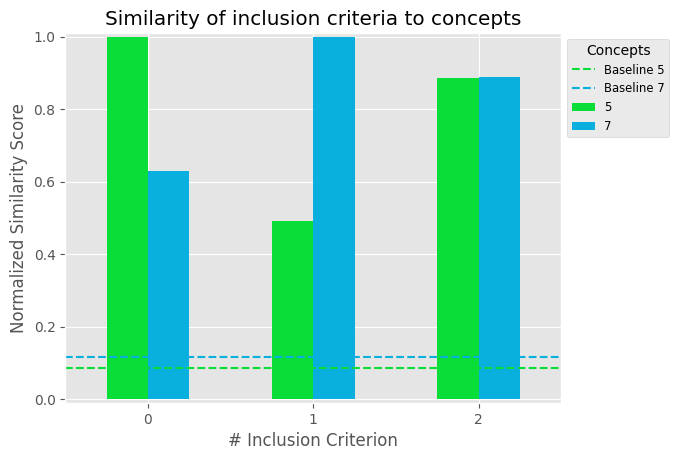

In [120]:
colors = np.array([
    (9/255, 221/255, 55/255, 1),     # green
    (9/255, 175/255, 221/255, 1),    # blue
    (221/255, 90/255, 9/255, 1),     # orange
    (9/255, 34/255, 221/255, 1),     # purple
    (221/255, 9/255, 34/255, 1),     # red
    (221/255, 9/255, 140/255, 1),    # pink
    (9/255, 221/255, 161/255, 1),    # turquoise
])

# plot similarity_df, using a bar chart with the concept ids on the x-axis and the similarity scores on the y-axis
plt.figure(figsize=(22, 4))
axes = similarity_df.iloc[:3].plot.bar(
    y=similarity_df.iloc[:3].columns[:-1],
    color=colors[:len(similarity_df.columns)-1],
    rot=0,
    title="Similarity of inclusion criteria to concepts",
)

for i, col in enumerate(similarity_df.columns[:-1]):
    axes.axhline(similarity_df[col][-3:].mean(), color=colors[i], linestyle='--', label=f"Baseline {col}")

# add dashed lines to legend as baseline
axes.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Concepts", fontsize='small')

axes.set_xlabel("# Inclusion Criterion")
axes.set_ylabel("Normalized Similarity Score")
axes.set_ylim(similarity_df.min(numeric_only=True).min()-0.01, similarity_df.max(numeric_only=True).max()+0.01)

# save plot in output folder
plt.savefig(f"output/{dataset}/{dataset}_similarity_plot.png", bbox_inches='tight', dpi=300)

# sentence occlusion without concepts

In [ ]:
text = df_concept_aligned.iloc[2].text

abstract_components = clause_tokenizer.tokenize(text)

perturbed_texts = [
    " ".join(s for j, s in enumerate(abstract_components) if j != i)
    for i in range(len(abstract_components))
]

full_abstract_classification = get_proba_from_cycle(EmbeddingNormalizer(simulate.cycles[0].feature_extractor.steps[1][1].fit_transform(text)).normalize().reshape(1, -1))[:,1]

embedded_texts = simulate.cycles[0].feature_extractor.steps[1][1].fit_transform(perturbed_texts)
normalized_embedded_texts = EmbeddingNormalizer(embedded_texts).normalize()

classification_alignment = - (get_proba_from_cycle(normalized_embedded_texts)[:, 1]) + full_abstract_classification
classification_alignment = classification_alignment * (1 / np.abs(classification_alignment).max())

# create dataframe with the perturbed texts and the classification alignment
df = pd.DataFrame({
    "sentence": abstract_components,
    "Positive Impact": np.clip(classification_alignment, 0, None),
    "Negative Impact": np.clip(-classification_alignment, 0, None),
})

colors = np.array(
    [
        "rgba(9, 221, 55, ",  # green
        "rgba(221, 9, 34, ",  # red
    ]
)

html = ""

for i, concept in enumerate(df.columns[1:]):
    html = html + f'<span style="background-color: {colors[i]} 0.5); margin: 7px; padding: 1px 5px; border: solid 3px ; border-color: {colors[i]} 1); #EFEFEF">{concept} </span>'

html = html + visualize_concepts(df, colors, 0.2, print=True)

imgkit.from_string(html, f'output/{dataset}/{dataset}_example_last_layer.png', config=Config(wkhtmltoimage=r"C:\Program Files\wkhtmltopdf\bin\wkhtmltoimage.exe"))

df

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


,sentence,Positive Impact,Negative Impact
0,Modeling the Effect of Size on Defect Pronenes...,0.000000,0.277684
1,Previous research has found that there is gene...,0.864780,0.000000
2,"Therefore,",0.515129,0.000000
3,"in open-source software development,",0.736408,0.000000
4,it is important to monitor module size and und...,0.045873,0.000000
5,"However,",0.693858,0.000000
6,"traditional approaches to quality modeling,",0.956804,0.000000
7,which measure specific system snapshots and ob...,0.637551,0.000000
8,are not well suited because open-source module...,0.809444,0.000000
9,"In this study,",0.253835,0.000000
